## Задание 4.
Рассмотрим датасет по предсказанию года создания песни по числовым признакам.
Информацию о датасете можно найти здесь: 
- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/c55b0b2354bd4ca5ac83fe5ed8b3eb92

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle.
Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, 
кроме ансамблирования и использования сторонних источников ДАННЫХ.
- Задание обязательно, базовое максимальное число баллов - 6. 
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд. 

# Предобработка
[Источник вдохновления](https://www.kaggle.com/code/raghav1810/release-year-prediction-on-msd-using-neural-nets)

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_x = pd.read_csv("../../datasets/YearPredictionMSD/train_x.csv", index_col=[0]) #, sep=","
df_y = pd.read_csv("../../datasets/YearPredictionMSD/train_y.csv", index_col=[0])
df = pd.merge(df_x, df_y, left_index=True, right_index=True)

#df.info()

In [323]:
df.describe()
#df.to_csv("df_describe()", sep='\t', index = False)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,43.394558,1.540279,8.378243,1.315349,-6.476035,-9.503415,-2.243164,-1.660698,3.543946,1.892996,...,-72.008182,41.154440,37.892338,0.145765,17.576243,-28.502296,4.474666,17.717701,1.227647,1998.366714
std,6.074562,51.578894,35.742553,16.622971,22.823521,12.926176,14.700348,8.035388,10.629817,6.602191,...,171.932584,120.075095,96.748418,16.162963,115.706029,180.463987,13.592096,185.335542,22.018997,11.048088
min,7.199890,-302.031900,-257.525600,-120.723150,-142.160680,-60.198620,-100.602550,-51.443820,-75.539550,-31.344160,...,-1976.846950,-791.832320,-1237.931680,-227.608010,-2678.193680,-3059.906060,-100.618700,-5000.654060,-286.031200,1922.000000
25%,39.970260,-25.603507,-11.773080,-8.490435,-20.716735,-18.524397,-10.651808,-6.402985,-2.573275,-2.446435,...,-138.560657,-21.424297,-4.443660,-7.027105,-32.236598,-101.305695,-2.563620,-60.364940,-8.873683,1994.000000
50%,44.282770,8.800720,10.226865,-0.582025,-5.808040,-11.254920,-2.007255,-1.516640,3.658655,1.763500,...,-52.984525,29.218730,33.576620,0.770135,15.522650,-22.050410,3.021435,6.982460,-0.050725,2002.000000
75%,47.843418,36.610743,29.596557,9.035892,7.858092,-2.198952,6.725500,3.111740,9.935210,6.245860,...,14.405743,89.374030,78.710667,8.380725,66.429958,50.378898,9.912000,86.542642,9.664982,2006.000000
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,1081.951340,1473.745210,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770,2011.000000


In [324]:
corr_matrix = df.corr()
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
0,1.000000,0.566384,0.238219,0.015581,-0.290998,-0.255993,0.150465,-0.056922,0.218639,0.100482,...,0.185610,-0.141162,0.043386,0.131090,-0.023281,0.060050,-0.151631,-0.090429,-0.181318,0.231402
1,0.566384,1.000000,0.003449,0.108685,-0.176475,-0.118153,0.093488,0.110959,0.139684,0.381411,...,0.068017,-0.160104,0.025871,0.147906,0.052706,0.001514,-0.020335,-0.117093,-0.143765,0.027011
2,0.238219,0.003449,1.000000,0.141888,-0.120211,0.058324,-0.056112,0.084467,0.032342,-0.103261,...,0.176158,0.105282,-0.013705,-0.038581,-0.103733,0.083694,-0.078674,-0.090521,0.096694,-0.142195
3,0.015581,0.108685,0.141888,1.000000,0.041031,0.316875,0.276893,0.033091,-0.068800,0.158218,...,-0.103787,0.064347,0.081510,-0.082989,0.065558,0.024398,0.263893,0.042521,0.004551,0.015034
4,-0.290998,-0.176475,-0.120211,0.041031,1.000000,0.012747,-0.099421,-0.004039,-0.218758,-0.090853,...,-0.094841,0.025572,-0.023188,0.013525,0.001245,-0.029810,-0.015504,-0.009246,0.031752,0.005840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.060050,0.001514,0.083694,0.024398,-0.029810,-0.030335,0.024270,0.020748,0.057749,0.021375,...,-0.015066,0.160687,0.360869,0.020517,0.015611,1.000000,-0.016337,0.182361,0.216426,0.021897
87,-0.151631,-0.020335,-0.078674,0.263893,-0.015504,0.137150,0.087998,0.047344,0.003349,0.068824,...,0.002216,0.267372,0.008950,-0.233718,0.091228,-0.016337,1.000000,0.058742,0.228683,-0.017512
88,-0.090429,-0.117093,-0.090521,0.042521,-0.009246,-0.003068,0.091808,-0.010945,0.024786,-0.021552,...,-0.064811,0.077995,0.127760,-0.017652,0.180202,0.182361,0.058742,1.000000,0.168630,0.005741
89,-0.181318,-0.143765,0.096694,0.004551,0.031752,0.019502,-0.067506,0.059553,0.048917,0.016578,...,-0.019252,0.090612,-0.029815,-0.155303,-0.025547,0.216426,0.228683,0.168630,1.000000,-0.050458


Text(0, 0.5, 'Number of songs')

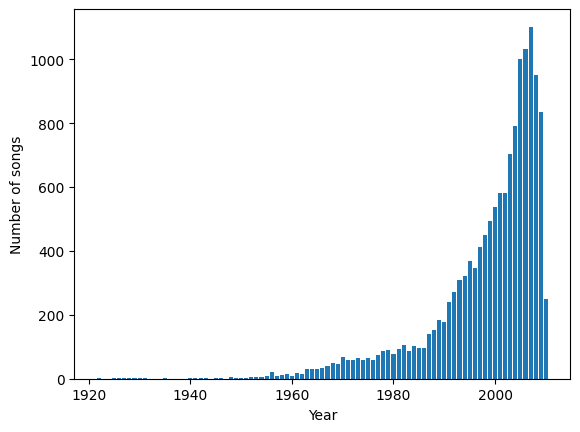

In [325]:
nsongs = {}
for y in range(1922,2012):
    nsongs[y] = len(df[df.year==y])
yrs = range(1922,2011)
values = [nsongs[y] for y in yrs]
plt.bar(yrs, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

In [326]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:, 0:90], df_y["year"], test_size=0.3)
X_train

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
445492,35.94055,-3.86011,-38.14904,17.04488,1.78849,17.46691,15.46660,0.58023,-17.18981,-7.94777,...,9.16669,-107.93431,65.70445,117.02651,-1.41435,156.88156,-237.79017,2.21242,93.25835,-22.08976
414354,48.04915,-2.92458,-14.44882,-5.11604,-35.27311,-19.10537,11.13688,-0.07743,8.34006,4.47740,...,8.74648,25.83805,-28.29628,91.39243,21.38136,17.31400,-256.20999,-2.89152,54.98874,-14.63322
436739,42.32236,-30.65069,90.35060,17.37058,-37.25571,5.06657,6.05743,-1.08164,-15.54174,-13.46226,...,-2.87918,-35.80943,71.42487,12.83694,-3.87903,27.41385,32.77536,2.07359,119.63167,2.47016
121220,42.92055,-136.76120,37.16478,-8.84838,-33.80624,-0.31519,-27.38165,-8.82088,-0.05515,-15.31894,...,107.53905,-636.66445,42.57961,-52.58420,-19.71310,47.80715,-54.09086,3.96707,587.94921,33.08866
237364,37.95998,9.89191,42.00985,-0.07441,9.54630,-21.96162,-21.61729,-11.75716,-1.73292,-5.60329,...,-1.62163,-156.70919,-81.65113,-112.05544,-10.20901,-85.90393,-5.75081,-6.76878,-10.72485,33.05842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245671,42.82944,29.90059,-18.74390,7.33395,9.26117,-22.04117,17.64267,0.43839,0.78413,10.00412,...,-9.82967,-110.49595,-59.55548,-292.78864,-47.61285,83.31983,-234.70224,30.83181,231.69585,125.68419
443449,43.93468,3.58816,-19.67838,-12.02611,8.69426,-4.53599,-0.86816,-2.76342,-0.56027,-7.83175,...,-7.47969,-162.62602,60.22073,54.33474,-17.97021,-44.18293,64.51754,-9.69631,11.67548,10.48900
488476,54.01836,60.11356,40.89359,-0.34975,-34.99443,-29.85230,15.64218,3.96915,-0.16257,10.68148,...,-1.22648,27.41511,40.61301,51.99155,-0.58983,-56.23775,39.83219,2.63849,20.21106,-3.47224
145122,44.61578,-27.69126,47.51291,9.54302,6.18378,-4.03933,-20.79304,-3.21806,3.14192,-5.55612,...,19.16183,-7.60593,165.27858,22.48090,7.59074,64.18734,-108.56678,3.54755,-100.75392,-16.21328


In [327]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std = pd.DataFrame(X_train_std,columns=X_train.columns)


In [328]:
# Make an instance of the Model
pca = PCA(.90)

# We fit to only our training set
pca.fit(X_train_std)
# Print number of components generated
pca.n_components_

54

In [329]:
X_train_proc = torch.tensor(pca.transform(X_train_std), dtype=torch.float)
X_test_proc = torch.tensor(pca.transform(X_test_std), dtype=torch.float)

/home/dima/Документы/Першин_Никольская_Нейронные_сети/myvenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [330]:
Y_train_proc = Y_train - min(Y_train)
Y_test_proc = Y_test - min(Y_test)

In [331]:
Y_train_hot = torch.tensor(to_categorical(Y_train_proc, 90), dtype=torch.float)
Y_test_hot = torch.tensor(to_categorical(Y_test_proc, 90), dtype=torch.float)

In [332]:
print(X_train_proc.shape)
print(Y_test_hot.shape)

torch.Size([9800, 54])
torch.Size([4200, 90])


# Нейросеть
[Источник вдохновления](https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/)

In [375]:
import torch.nn as nn


class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(54, 30)
#        self.act1 = nn.Sigmoid()
#        self.hidden1 = nn.Linear(30, 30)
#        self.act2 = nn.Sigmoid()
#        self.hidden2 = nn.Linear(30, 30)
#        self.act3 = nn.Sigmoid()
        self.hidden = nn.Linear(30, 90)
        self.output = nn.Softmax()
        

        
    def forward (self, x):
        x = self.input(x)
#        x = self.act1(x)
#        x = self.hidden1(x)
#        x = self.act2(x)
#        x = self.hidden2(x)
#        x = self.act3(x)
        x = self.hidden(x)
#        x = self.act(x)
        return self.output(x)

model = Multiclass()

In [376]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


In [377]:
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

n_epochs = 150
for epoch in range(n_epochs):
    y_pred = model(X_train_proc)
    loss = loss_fn(y_pred, Y_train_hot)
    epoch_loss = loss
    epoch_acc = (torch.argmax(y_pred, 1) == torch.argmax(Y_train_hot, 1)).float().mean()

    #print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_proc)
    ce = loss_fn(y_pred, Y_test_hot)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(Y_test_hot, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
#    train_loss_hist.append(np.mean(epoch_loss))
#    train_acc_hist.append(np.mean(epoch_acc))
    train_loss_hist.append(epoch_loss.item())
    train_acc_hist.append(epoch_acc.item())
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
#        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")



Epoch 0 validation: Cross-entropy=4.499641418457031, Accuracy=0.013333333656191826
Epoch 1 validation: Cross-entropy=4.4995808601379395, Accuracy=0.014285714365541935
Epoch 2 validation: Cross-entropy=4.499520301818848, Accuracy=0.014999999664723873
Epoch 3 validation: Cross-entropy=4.499457836151123, Accuracy=0.015238095074892044
Epoch 4 validation: Cross-entropy=4.499393939971924, Accuracy=0.015238095074892044
Epoch 5 validation: Cross-entropy=4.499329566955566, Accuracy=0.017142856493592262
Epoch 6 validation: Cross-entropy=4.499262809753418, Accuracy=0.018333332613110542
Epoch 7 validation: Cross-entropy=4.499195575714111, Accuracy=0.018571428954601288
Epoch 8 validation: Cross-entropy=4.49912691116333, Accuracy=0.019285714253783226
Epoch 9 validation: Cross-entropy=4.499056816101074, Accuracy=0.019999999552965164
Epoch 10 validation: Cross-entropy=4.498985767364502, Accuracy=0.02023809589445591
Epoch 11 validation: Cross-entropy=4.498913288116455, Accuracy=0.02190476283431053
Epoc

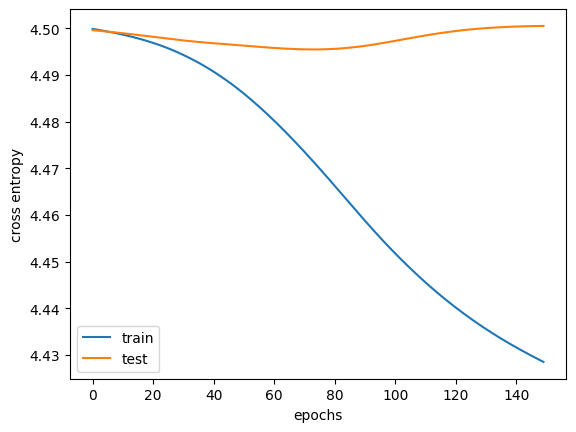

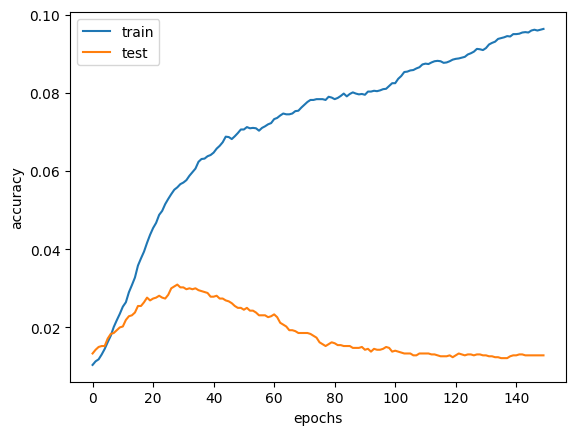

In [378]:

import matplotlib.pyplot as plt
 
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [337]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, label)

NameError: name 'output' is not defined